2021 ~ 2023년  
월말 데이터 중 샘플링해서 토픽모델링 진행  
+ 데이터는 10번 파일에서 추출한 것 기준으로 진행, 그대신에 Bertopic에 파라미터 추가하여 모델링  
+ 결과가 별로....ㅎ  

In [89]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import re
from umap import UMAP
from hdbscan import HDBSCAN
import torch
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel
from collections.abc import Iterable
from transformers import AutoTokenizer, AutoModel
from bertopic import BERTopic
import torch
from collections import deque
from bertopic.representation import KeyBERTInspired
from tqdm import tqdm
from sklearn.cluster import KMeans
import calendar
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import openai
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech

In [90]:
# sample_df
# 전체 데이터셋 
with open('../../data/sample_df.pkl', 'rb') as f:
    sample_df = pickle.load(f)

In [91]:
with open('../../data/sample_src_df.pkl', 'rb') as f:
    sample_src_df = pickle.load(f)

In [51]:
# 파일 불러오기
with open('../../data/embed_text_list.pkl', 'rb') as f:
    embed_text_list = pickle.load(f)


In [52]:
# 파일 불러오기
with open('../../data/data.pkl', 'rb') as f:
    data = pickle.load(f)


In [53]:
# 파일 불러오기
with open('../../data/reserved_list.pkl', 'rb') as f:
    reserved_list = pickle.load(f)


In [54]:
type(reserved_list)

list

In [55]:
# CodeBERT 모델과 토크나이저 로드
model_name = "microsoft/codebert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [56]:
# 모든 텍스트에 대한 임베딩 계산
embeddings = torch.cat(embed_text_list, dim=0).numpy()  # 텐서로 연결 후 numpy 배열로 변환

In [57]:
embeddings.shape

(41900, 768)

In [58]:
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

In [59]:
hdbscan_model = HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
cluster_model = KMeans(n_clusters=30)

In [75]:
# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
# pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# GPT-3.5
prompt = """
I have a topic that contains the documents: [REPRESENTATIVE_DOCUMENT]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""
client = openai.OpenAI(api_key="sk-proj-Mm0FIOmjCUgXc2T40TarT3BlbkFJ7YO5SE9kJokyhFrRxEiB")
openai_model = OpenAI(client, model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    "OpenAI": openai_model,  # Uncomment if you will use OpenAI
    "MMR": mmr_model
    # ,
    # "POS": pos_model
}

In [76]:
vectorizer_model = CountVectorizer(stop_words=reserved_list, min_df=2, ngram_range=(1, 2))

In [77]:
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)


In [125]:
# BERTopic 모델 초기화 및 훈련
topic_model = BERTopic( embedding_model=model,
                        umap_model=umap_model,
                        # hdbscan_model=hdbscan_model,
                        hdbscan_model=cluster_model,
                        ctfidf_model=ctfidf_model,
                        vectorizer_model = vectorizer_model,
                        representation_model=representation_model)  # 임베딩 모델 사용을 비활성화
topics, probabilities = topic_model.fit_transform(data, embeddings)


In [126]:
# 결과 출력
print(topic_model.get_topic_info())  # 토픽 정보 출력

    Topic  Count                                               Name  \
0       0   5095                  0_scrollbar_pod_dockerfile_spanid   
1       1   3531                                1_df_foo_select_amp   
2       2   3359           2_elemnt_elemnt elemnt_localhost_install   
3       3   3257                           3_public_string_new_this   
4       4   2928                           4_000 000_000_cannot_x00   
5       5   2862             5_unknown unknown_rbf_precomputed_poly   
6       6   2703                         6_const_this_new_classname   
7       7   2490                                    7_self_np_na_1l   
8       8   2268                   8_public_background_border_color   
9       9   2043                          9_npm run_install_npm_git   
10     10   2009                              10_at_java_at org_lib   
11     11   1729           11_feature feature_feature_lock lock_ger   
12     12   1458                        12_gt lt_quot gt_lt div_div   
13    

In [127]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,OpenAI,MMR,Representative_Docs
0,0,5095,0_scrollbar_pod_dockerfile_spanid,"[scrollbar, pod, dockerfile, spanid, your text...","[scrollbar, form page, page, user form, page u...",[Scrollbar Pod Dockerfile Spanid Webview],"[scrollbar, pod, dockerfile, spanid, your text...","[pod install, User Form Page, User Form Page]"
1,1,3531,1_df_foo_select_amp,"[df, foo, select, amp, name, where, gt gt, end...","[name, john, name quot, json, curl, group, dat...",[Data Selection and Filtering Tests],"[df, foo, select, amp, name, where, gt gt, end...",[curl --silent --show-error -L -X POST &quot;h...
2,2,3359,2_elemnt_elemnt elemnt_localhost_install,"[elemnt, elemnt elemnt, localhost, install, lo...","[pip install, manage py, pip3, pip, modulenotf...",[Server Installation Errors Solution],"[elemnt, elemnt elemnt, localhost, install, lo...",[/etc/pki/ca-trust/extracted/pem/tls-ca-bundle...
3,3,3257,3_public_string_new_this,"[public, string, new, this, const, void, var, ...","[null, get set, public void, error, static voi...",[Programming fundamentals and concepts],"[public, string, new, this, const, void, var, ...",[using Microsoft.EntityFrameworkCore;\nusing S...
4,4,2928,4_000 000_000_cannot_x00,"[000 000, 000, cannot, x00, found, to, the, of...","[typeerror cannot, typeerror, error, invalid, ...",[Unidentified Image Representation],"[000 000, 000, cannot, x00, found, to, the, of...",[ 'type' does not contain a definition for 'na...
5,5,2862,5_unknown unknown_rbf_precomputed_poly,"[unknown unknown, rbf, precomputed, poly, sigm...","[table1, table, dataframe, group by, df1, pd d...",[Kernel Methods for Classification],"[unknown unknown, rbf, precomputed, poly, sigm...",[update table1 t1 set t4.datum = t.datum\nfrom...
6,6,2703,6_const_this_new_classname,"[const, this, new, classname, var, the, string...","[react, usestate, quot const, const, button, p...",[Object-Oriented Programming Fundamentals],"[const, this, new, classname, var, the, string...",[class Intercom {\n /// private constructor t...
7,7,2490,7_self_np_na_1l,"[self, np, na, 1l, df, end, c3, na na, dim, sl...","[numpy, numpy np, tf keras, keras, plot, data ...",[Self-representation in sleep analysis],"[self, np, na, 1l, df, end, c3, na na, dim, sl...",[import numpy as np\nfrom keras.models import ...
8,8,2268,8_public_background_border_color,"[public, background, border, color, margin, ba...","[margin top, background color, display flex, m...",[Styling Web Page Elements],"[public, background, border, color, margin, ba...",[* {\n margin: 0;\n box-sizing: border-box\n...
9,9,2043,9_npm run_install_npm_git,"[npm run, install, npm, git, docker compose, c...","[docker compose, docker, compose up, docker pu...",[Dockerized npm Installation with Git],"[npm run, install, npm, git, docker compose, c...","[docker compose up, docker-compose up -d, dock..."


In [128]:
topic_model.get_topic(0)

[('scrollbar', 0.41966175039641973),
 ('pod', 0.3297022639699186),
 ('dockerfile', 0.29674060531508045),
 ('spanid', 0.2949959001923368),
 ('your text', 0.2923286310491116),
 ('yarn', 0.2912253559539932),
 ('nls', 0.28974244613711136),
 ('ssm ssm', 0.28974244613711136),
 ('form page', 0.28974244613711136),
 ('webview', 0.2847380824458261)]

In [129]:
topic_model.get_topic(1)

[('df', 0.19139235246275216),
 ('foo', 0.1805217969099929),
 ('select', 0.1676932631789555),
 ('amp', 0.1618631571296677),
 ('name', 0.1606033330139786),
 ('where', 0.1551573904053522),
 ('gt gt', 0.15458779970592212),
 ('end', 0.14793856528224394),
 ('test', 0.1474695927401739),
 ('data', 0.14729518701493188)]

In [130]:
topic_model.get_topic(6, full=True)

{'Main': [('const', 0.22803404083073767),
  ('this', 0.19511332070834186),
  ('new', 0.19429944612263847),
  ('classname', 0.1894744053314764),
  ('var', 0.18329867336233774),
  ('the', 0.17919734134784532),
  ('string', 0.17603662775173512),
  ('amp', 0.1735908734504192),
  ('function', 0.17228440847929127),
  ('let', 0.17211065382607643)],
 'KeyBERT': [('react', 0.53489137),
  ('usestate', 0.45105374),
  ('quot const', 0.3088873),
  ('const', 0.27976972),
  ('button', 0.22919855),
  ('props', 0.2001075),
  ('gt const', 0.18108594),
  ('form', 0.18080057),
  ('error', 0.17669988),
  ('json', 0.15363276)],
 'OpenAI': [('Object-Oriented Programming Fundamentals', 1)],
 'MMR': [('const', 0.22803404083073767),
  ('this', 0.19511332070834186),
  ('new', 0.19429944612263847),
  ('classname', 0.1894744053314764),
  ('var', 0.18329867336233774),
  ('the', 0.17919734134784532),
  ('string', 0.17603662775173512),
  ('amp', 0.1735908734504192),
  ('function', 0.17228440847929127),
  ('let', 0.17

In [131]:
# # Label the topics yourself
# topic_model.set_topic_labels({1: "Space Travel", 7: "Religion"})

# # or use one of the other topic representations, like KeyBERTInspired
# keybert_topic_labels = {topic: " | ".join(list(zip(*values))[0][:3]) for topic, values in topic_model.topic_aspects_["KeyBERT"].items()}
# topic_model.set_topic_labels(keybert_topic_labels)

# # or ChatGPT's labels
# chatgpt_topic_labels = {topic: " | ".join(list(zip(*values))[0]) for topic, values in topic_model.topic_aspects_["OpenAI"].items()}
# chatgpt_topic_labels[-1] = "Outlier Topic"
# topic_model.set_topic_labels(chatgpt_topic_labels)

In [132]:
# topic_distr, _ = topic_model.approximate_distribution(data, window=8, stride=4)

In [133]:
# pip install nbformat>=4.2.0

In [134]:
# Visualize the topic-document distribution for a single document
topic_model.visualize_topics()

In [135]:
topic_model.visualize_hierarchy()

In [ ]:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

In [ ]:
topic_model.visualize_documents(data, embeddings=embeddings)

In [ ]:
topic_model.visualize_documents(data, reduced_embeddings=reduced_embeddings)

In [136]:
topa_df = topic_model.get_document_info(data)

In [137]:
topa_df

,Document,Topic,Name,Representation,KeyBERT,OpenAI,MMR,Representative_Docs,Top_n_words,Representative_document
0,let playerRecentStats = [];\n\tfunction recent...,6,6_const_this_new_classname,"[const, this, new, classname, var, the, string...","[react, usestate, quot const, const, button, p...",[Object-Oriented Programming Fundamentals],"[const, this, new, classname, var, the, string...",[class Intercom {\n /// private constructor t...,const - this - new - classname - var - the - s...,False
1,3.9,2,2_elemnt_elemnt elemnt_localhost_install,"[elemnt, elemnt elemnt, localhost, install, lo...","[pip install, manage py, pip3, pip, modulenotf...",[Server Installation Errors Solution],"[elemnt, elemnt elemnt, localhost, install, lo...",[/etc/pki/ca-trust/extracted/pem/tls-ca-bundle...,elemnt - elemnt elemnt - localhost - install -...,False
2,myCollection2,9,9_npm run_install_npm_git,"[npm run, install, npm, git, docker compose, c...","[docker compose, docker, compose up, docker pu...",[Dockerized npm Installation with Git],"[npm run, install, npm, git, docker compose, c...","[docker compose up, docker-compose up -d, dock...",npm run - install - npm - git - docker compose...,False
3,float,0,0_scrollbar_pod_dockerfile_spanid,"[scrollbar, pod, dockerfile, spanid, your text...","[scrollbar, form page, page, user form, page u...",[Scrollbar Pod Dockerfile Spanid Webview],"[scrollbar, pod, dockerfile, spanid, your text...","[pod install, User Form Page, User Form Page]",scrollbar - pod - dockerfile - spanid - your t...,False
4,FOR i IN 1..998700000\n INSERT {\n\t\ttitle: ...,7,7_self_np_na_1l,"[self, np, na, 1l, df, end, c3, na na, dim, sl...","[numpy, numpy np, tf keras, keras, plot, data ...",[Self-representation in sleep analysis],"[self, np, na, 1l, df, end, c3, na na, dim, sl...",[import numpy as np\nfrom keras.models import ...,self - np - na - 1l - df - end - c3 - na na - ...,False
...,...,...,...,...,...,...,...,...,...,...
41895,body {\n text-align: center;\n font-size: xx...,8,8_public_background_border_color,"[public, background, border, color, margin, ba...","[margin top, background color, display flex, m...",[Styling Web Page Elements],"[public, background, border, color, margin, ba...",[* {\n margin: 0;\n box-sizing: border-box\n...,public - background - border - color - margin ...,False
41896,"var Bucharest = new Date(&quot;April 26, 2023 ...",6,6_const_this_new_classname,"[const, this, new, classname, var, the, string...","[react, usestate, quot const, const, button, p...",[Object-Oriented Programming Fundamentals],"[const, this, new, classname, var, the, string...",[class Intercom {\n /// private constructor t...,const - this - new - classname - var - the - s...,False
41897,gradeDelete = int(input(&quot;Which grade do y...,4,4_000 000_000_cannot_x00,"[000 000, 000, cannot, x00, found, to, the, of...","[typeerror cannot, typeerror, error, invalid, ...",[Unidentified Image Representation],"[000 000, 000, cannot, x00, found, to, the, of...",[ 'type' does not contain a definition for 'na...,000 000 - 000 - cannot - x00 - found - to - th...,False
41898,"grades = {&quot;english&quot;:[90,95,81],\n\t ...",1,1_df_foo_select_amp,"[df, foo, select, amp, name, where, gt gt, end...","[name, john, name quot, json, curl, group, dat...",[Data Selection and Filtering Tests],"[df, foo, select, amp, name, where, gt gt, end...",[curl --silent --show-error -L -X POST &quot;h...,df - foo - select - amp - name - where - gt gt...,False


In [138]:
sample_src_df[sample_src_df['q_id'] ==77394187]

,q_id,q_prep_text,q_prep_text_non
13273,77394187,Scrollbar,Scrollbar
13273,77394187,ListBox,ListBox
13273,77394187,ListBox,ListBox
13273,77394187,Scrollbar,Scrollbar
13273,77394187,Scrollbar,Scrollbar
13273,77394187,ListBox,ListBox
13273,77394187,Scrollbar,Scrollbar
13273,77394187,ListBox,ListBox
13273,77394187,import tkinter as tk\n\ndef main():\n mainW...,import tkinter as tk\ndef main():\n\tmainWindo...
13273,77394187,Scrollbar,Scrollbar


In [139]:
topa_org_df = sample_src_df.copy()
topa_org_df.reset_index(drop=True, inplace=True)
topa_df.reset_index(drop=True, inplace=True)

In [140]:
tot_topa_df = pd.concat([topa_org_df, topa_df], axis = 1)

In [141]:
tot_topa_df

,q_id,q_prep_text,q_prep_text_non,Document,Topic,Name,Representation,KeyBERT,OpenAI,MMR,Representative_Docs,Top_n_words,Representative_document
0,72071464,let playerRecentStats = [];\n function rece...,let playerRecentStats = [];\n\tfunction recent...,let playerRecentStats = [];\n\tfunction recent...,6,6_const_this_new_classname,"[const, this, new, classname, var, the, string...","[react, usestate, quot const, const, button, p...",[Object-Oriented Programming Fundamentals],"[const, this, new, classname, var, the, string...",[class Intercom {\n /// private constructor t...,const - this - new - classname - var - the - s...,False
1,72065084,3.9,3.9,3.9,2,2_elemnt_elemnt elemnt_localhost_install,"[elemnt, elemnt elemnt, localhost, install, lo...","[pip install, manage py, pip3, pip, modulenotf...",[Server Installation Errors Solution],"[elemnt, elemnt elemnt, localhost, install, lo...",[/etc/pki/ca-trust/extracted/pem/tls-ca-bundle...,elemnt - elemnt elemnt - localhost - install -...,False
2,72065084,myCollection2,myCollection2,myCollection2,9,9_npm run_install_npm_git,"[npm run, install, npm, git, docker compose, c...","[docker compose, docker, compose up, docker pu...",[Dockerized npm Installation with Git],"[npm run, install, npm, git, docker compose, c...","[docker compose up, docker-compose up -d, dock...",npm run - install - npm - git - docker compose...,False
3,72065084,float,float,float,0,0_scrollbar_pod_dockerfile_spanid,"[scrollbar, pod, dockerfile, spanid, your text...","[scrollbar, form page, page, user form, page u...",[Scrollbar Pod Dockerfile Spanid Webview],"[scrollbar, pod, dockerfile, spanid, your text...","[pod install, User Form Page, User Form Page]",scrollbar - pod - dockerfile - spanid - your t...,False
4,72065084,FOR i IN 1..998700000\n INSERT {\n tit...,FOR i IN 1..998700000\n INSERT {\n\t\ttitle: ...,FOR i IN 1..998700000\n INSERT {\n\t\ttitle: ...,7,7_self_np_na_1l,"[self, np, na, 1l, df, end, c3, na na, dim, sl...","[numpy, numpy np, tf keras, keras, plot, data ...",[Self-representation in sleep analysis],"[self, np, na, 1l, df, end, c3, na na, dim, sl...",[import numpy as np\nfrom keras.models import ...,self - np - na - 1l - df - end - c3 - na na - ...,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41895,76142192,body {\n text-align: center;\n font-size: xx...,body {\n text-align: center;\n font-size: xx...,body {\n text-align: center;\n font-size: xx...,8,8_public_background_border_color,"[public, background, border, color, margin, ba...","[margin top, background color, display flex, m...",[Styling Web Page Elements],"[public, background, border, color, margin, ba...",[* {\n margin: 0;\n box-sizing: border-box\n...,public - background - border - color - margin ...,False
41896,76142192,"var Bucharest = new Date(&quot;April 26, 2023 ...","var Bucharest = new Date(&quot;April 26, 2023 ...","var Bucharest = new Date(&quot;April 26, 2023 ...",6,6_const_this_new_classname,"[const, this, new, classname, var, the, string...","[react, usestate, quot const, const, button, p...",[Object-Oriented Programming Fundamentals],"[const, this, new, classname, var, the, string...",[class Intercom {\n /// private constructor t...,const - this - new - classname - var - the - s...,False
41897,76139757,gradeDelete = int(input(&quot;Which grade do y...,gradeDelete = int(input(&quot;Which grade do y...,gradeDelete = int(input(&quot;Which grade do y...,4,4_000 000_000_cannot_x00,"[000 000, 000, cannot, x00, found, to, the, of...","[typeerror cannot, typeerror, error, invalid, ...",[Unidentified Image Representation],"[000 000, 000, cannot, x00, found, to, the, of...",[ 'type' does not contain a definition for 'na...,000 000 - 000 - cannot - x00 - found - to - th...,False
41898,76139757,"grades = {&quot;english&quot;:[90,95,81],\n ...","grades = {&quot;english&quot;:[90,95,81],\n\t ...","grades = {&quot;english&quot;:[90,95,81],\n\t ...",1,1_df_foo_select_amp,"[df, foo, select, amp, name, where, gt gt, end...","[

In [142]:
tot_topa_df[(tot_topa_df['Topic'] ==0)&(tot_topa_df['Representative_document'] ==True)]

,q_id,q_prep_text,q_prep_text_non,Document,Topic,Name,Representation,KeyBERT,OpenAI,MMR,Representative_Docs,Top_n_words,Representative_document
1776,74625400,pod install,pod install,pod install,0,0_scrollbar_pod_dockerfile_spanid,"[scrollbar, pod, dockerfile, spanid, your text...","[scrollbar, form page, page, user form, page u...",[Scrollbar Pod Dockerfile Spanid Webview],"[scrollbar, pod, dockerfile, spanid, your text...","[pod install, User Form Page, User Form Page]",scrollbar - pod - dockerfile - spanid - your t...,True
1779,74625400,pod install,pod install,pod install,0,0_scrollbar_pod_dockerfile_spanid,"[scrollbar, pod, dockerfile, spanid, your text...","[scrollbar, form page, page, user form, page u...",[Scrollbar Pod Dockerfile Spanid Webview],"[scrollbar, pod, dockerfile, spanid, your text...","[pod install, User Form Page, User Form Page]",scrollbar - pod - dockerfile - spanid - your t...,True
10109,70177465,pod install,pod install,pod install,0,0_scrollbar_pod_dockerfile_spanid,"[scrollbar, pod, dockerfile, spanid, your text...","[scrollbar, form page, page, user form, page u...",[Scrollbar Pod Dockerfile Spanid Webview],"[scrollbar, pod, dockerfile, spanid, your text...","[pod install, User Form Page, User Form Page]",scrollbar - pod - dockerfile - spanid - your t...,True
16451,73187631,User Form Page,User Form Page,User Form Page,0,0_scrollbar_pod_dockerfile_spanid,"[scrollbar, pod, dockerfile, spanid, your text...","[scrollbar, form page, page, user form, page u...",[Scrollbar Pod Dockerfile Spanid Webview],"[scrollbar, pod, dockerfile, spanid, your text...","[pod install, User Form Page, User Form Page]",scrollbar - pod - dockerfile - spanid - your t...,True
16456,73187631,User Form Page,User Form Page,User Form Page,0,0_scrollbar_pod_dockerfile_spanid,"[scrollbar, pod, dockerfile, spanid, your text...","[scrollbar, form page, page, user form, page u...",[Scrollbar Pod Dockerfile Spanid Webview],"[scrollbar, pod, dockerfile, spanid, your text...","[pod install, User Form Page, User Form Page]",scrollbar - pod - dockerfile - spanid - your t...,True
16460,73187631,User Form Page,User Form Page,User Form Page,0,0_scrollbar_pod_dockerfile_spanid,"[scrollbar, pod, dockerfile, spanid, your text...","[scrollbar, form page, page, user form, page u...",[Scrollbar Pod Dockerfile Spanid Webview],"[scrollbar, pod, dockerfile, spanid, your text...","[pod install, User Form Page, User Form Page]",scrollbar - pod - dockerfile - spanid - your t...,True
16463,73187631,User Form Page,User Form Page,User Form Page,0,0_scrollbar_pod_dockerfile_spanid,"[scrollbar, pod, dockerfile, spanid, your text...","[scrollbar, form page, page, user form, page u...",[Scrollbar Pod Dockerfile Spanid Webview],"[scrollbar, pod, dockerfile, spanid, your text...","[pod install, User Form Page, User Form Page]",scrollbar - pod - dockerfile - spanid - your t...,True
16465,73187631,User Form Page,User Form Page,User Form Page,0,0_scrollbar_pod_dockerfile_spanid,"[scrollbar, pod, dockerfile, spanid, your text...","[scrollbar, form page, page, user form, page u...",[Scrollbar Pod Dockerfile Spanid Webview],"[scrollbar, pod, dockerfile, spanid, your text...","[pod install, User Form Page, User Form Page]",scrollbar - pod - dockerfile - spanid - your t...,True
16468,73187631,User Form Page,User Form Page,User Form Page,0,0_scrollbar_pod_dockerfile_spanid,"[scrollbar, pod, dockerfile, spanid, your text...","[scrollbar, form page, page, user form, page u...",[Scrollbar Pod Dockerfile Spanid Webview],"[scrollbar, pod, dockerfile, spanid, your text...","[pod install, User Form Page, User Form Page]",scrollbar - pod - dockerfile - spanid - your t...,True
37087,77397824,pod install,pod install,pod install,0,0_scrollbar_pod_dockerfile_spanid,"[scrollbar, pod, dockerfile, spanid, your text...","[scrollbar, form page, page, user form, page u...",[Scrollbar Pod Dockerfile Spanid Webview],"[scrollbar, pod, dockerfile, spanid, your text...","[pod install, User Form Pa

In [143]:
sample_dropnull_df = sample_df[['q_id', 'q_creationdate', 'a_id']].groupby(['q_id', 'q_creationdate']).head(1)

In [144]:
tot_topa_df = pd.merge(tot_topa_df, sample_dropnull_df, how='left', left_on = 'q_id', right_on = 'q_id')

In [145]:
tot_topa_df[tot_topa_df['q_id'] == 77394187]

,q_id,q_prep_text,q_prep_text_non,Document,Topic,Name,Representation,KeyBERT,OpenAI,MMR,Representative_Docs,Top_n_words,Representative_document,q_creationdate,a_id
36492,77394187,Scrollbar,Scrollbar,Scrollbar,0,0_scrollbar_pod_dockerfile_spanid,"[scrollbar, pod, dockerfile, spanid, your text...","[scrollbar, form page, page, user form, page u...",[Scrollbar Pod Dockerfile Spanid Webview],"[scrollbar, pod, dockerfile, spanid, your text...","[pod install, User Form Page, User Form Page]",scrollbar - pod - dockerfile - spanid - your t...,False,2023-10-31 08:06:39.087,77394257.0
36493,77394187,ListBox,ListBox,ListBox,28,28_listbox_prod prod_prod_listb,"[listbox, prod prod, prod, listb, info info, l...","[listbox, listb, listservicename, info, info i...",[Information on Listbox Features],"[listbox, prod prod, prod, listb, info info, l...","[ListBox, listBox, ListBox]",listbox - prod prod - prod - listb - info info...,True,2023-10-31 08:06:39.087,77394257.0
36494,77394187,ListBox,ListBox,ListBox,28,28_listbox_prod prod_prod_listb,"[listbox, prod prod, prod, listb, info info, l...","[listbox, listb, listservicename, info, info i...",[Information on Listbox Features],"[listbox, prod prod, prod, listb, info info, l...","[ListBox, listBox, ListBox]",listbox - prod prod - prod - listb - info info...,True,2023-10-31 08:06:39.087,77394257.0
36495,77394187,Scrollbar,Scrollbar,Scrollbar,0,0_scrollbar_pod_dockerfile_spanid,"[scrollbar, pod, dockerfile, spanid, your text...","[scrollbar, form page, page, user form, page u...",[Scrollbar Pod Dockerfile Spanid Webview],"[scrollbar, pod, dockerfile, spanid, your text...","[pod install, User Form Page, User Form Page]",scrollbar - pod - dockerfile - spanid - your t...,False,2023-10-31 08:06:39.087,77394257.0
36496,77394187,Scrollbar,Scrollbar,Scrollbar,0,0_scrollbar_pod_dockerfile_spanid,"[scrollbar, pod, dockerfile, spanid, your text...","[scrollbar, form page, page, user form, page u...",[Scrollbar Pod Dockerfile Spanid Webview],"[scrollbar, pod, dockerfile, spanid, your text...","[pod install, User Form Page, User Form Page]",scrollbar - pod - dockerfile - spanid - your t...,False,2023-10-31 08:06:39.087,77394257.0
36497,77394187,ListBox,ListBox,ListBox,28,28_listbox_prod prod_prod_listb,"[listbox, prod prod, prod, listb, info info, l...","[listbox, listb, listservicename, info, info i...",[Information on Listbox Features],"[listbox, prod prod, prod, listb, info info, l...","[ListBox, listBox, ListBox]",listbox - prod prod - prod - listb - info info...,True,2023-10-31 08:06:39.087,77394257.0
36498,77394187,Scrollbar,Scrollbar,Scrollbar,0,0_scrollbar_pod_dockerfile_spanid,"[scrollbar, pod, dockerfile, spanid, your text...","[scrollbar, form page, page, user form, page u...",[Scrollbar Pod Dockerfile Spanid Webview],"[scrollbar, pod, dockerfile, spanid, your text...","[pod install, User Form Page, User Form Page]",scrollbar - pod - dockerfile - spanid - your t...,False,2023-10-31 08:06:39.087,77394257.0
36499,77394187,ListBox,ListBox,ListBox,28,28_listbox_prod prod_prod_listb,"[listbox, prod prod, prod, listb, info info, l...","[listbox, listb, listservicename, info, info i...",[Information on Listbox Features],"[listbox, prod prod, prod, listb, info info, l...","[ListBox, listBox, ListBox]",listbox - prod prod - prod - listb - info info...,True,2023-10-31 08:06:39.087,77394257.0
36500,77394187,import tkinter as tk\n\ndef main():\n mainW...,import tkinter as tk\ndef main():\n\tmainWindo...,import tkinter as tk\ndef main():\n\tmainWindo...,7,7_self_np_na_1l,"[self, np, na, 1l, df, end, c3, na na, dim, sl...","[numpy, numpy np, tf keras, keras, plot, data ...",[Self-representation in sleep analysis],"[self, np, na, 1l, df, end, c3, na na, dim, sl...",[import numpy as np\nfrom keras.models import ...,self - np - na - 1l - df - end - c3 - na na - ...,False,2023-10-31 08:06:39.087,77394257.0
36501,77394187,Scrollbar,Scrollbar,Scrollbar,0,0_scrollbar_pod_dockerfile_spanid,"[scrollbar, pod, dockerfile, 

In [146]:
tot_topa_df['date'] = pd.to_datetime(tot_topa_df['q_creationdate']).dt.date

In [147]:
tot_topa_not_answered_df = tot_topa_df[tot_topa_df['a_id'].isna()]
tot_topa_answered_df = tot_topa_df[tot_topa_df['a_id'].isna()==False]

In [148]:
tot_topa_not_answered_rate = tot_topa_not_answered_df.groupby(['date', 'Topic']).count()[['q_id']].reset_index()
tot_topa_answered_rate = tot_topa_answered_df.groupby(['date', 'Topic']).count()[['q_id']].reset_index()

In [149]:
tot_topa_not_answered_sum = tot_topa_not_answered_rate.groupby(['date']).sum()[['q_id']].reset_index()
tot_topa_answered_sum = tot_topa_answered_rate.groupby(['date']).sum()[['q_id']].reset_index()

In [150]:
tot_topa_not_answered_rate = pd.merge(tot_topa_not_answered_rate, tot_topa_not_answered_sum, on = 'date')
tot_topa_answered_rate = pd.merge(tot_topa_answered_rate, tot_topa_answered_sum, on = 'date')

In [151]:
tot_topa_not_answered_rate

,date,Topic,q_id_x,q_id_y
0,2021-11-30,0,99,833
1,2021-11-30,1,62,833
2,2021-11-30,2,65,833
3,2021-11-30,3,67,833
4,2021-11-30,4,56,833
...,...,...,...,...
647,2023-11-30,21,4,587
648,2023-11-30,22,1,587
649,2023-11-30,23,2,587
650,2023-11-30,25,3,587


In [152]:
# topic_per_rate = tot_topa_not_answered_rate.rename({'q_id_x': 'cnt', 'q_id_y':'tot_cnt'})

In [153]:
tot_topa_not_answered_rate['rate'] = tot_topa_not_answered_rate['q_id_x']/tot_topa_not_answered_rate['q_id_y']*100
tot_topa_answered_rate['rate'] = tot_topa_answered_rate['q_id_x']/tot_topa_answered_rate['q_id_y']*100


In [154]:
tot_topa_not_answered_rate

,date,Topic,q_id_x,q_id_y,rate
0,2021-11-30,0,99,833,11.884754
1,2021-11-30,1,62,833,7.442977
2,2021-11-30,2,65,833,7.803121
3,2021-11-30,3,67,833,8.043217
4,2021-11-30,4,56,833,6.722689
...,...,...,...,...,...
647,2023-11-30,21,4,587,0.681431
648,2023-11-30,22,1,587,0.170358
649,2023-11-30,23,2,587,0.340716
650,2023-11-30,25,3,587,0.511073


In [155]:
tot_topa_not_answered_rate_pivot = pd.pivot_table(tot_topa_not_answered_rate, index = 'date', columns = 'Topic',values = 'rate').reset_index()
tot_topa_answered_rate_pivot = pd.pivot_table(tot_topa_answered_rate, index = 'date', columns = 'Topic',values = 'rate').reset_index()

In [169]:
tot_topa_not_answered_pivot = pd.pivot_table(tot_topa_not_answered_rate, index = 'date', columns = 'Topic',values = 'q_id_x').reset_index()
tot_topa_answered_pivot = pd.pivot_table(tot_topa_answered_rate, index = 'date', columns = 'Topic',values = 'q_id_x').reset_index()

In [156]:
tot_topa_not_answered_rate_pivot.fillna(0, inplace=True)
tot_topa_answered_rate_pivot.fillna(0, inplace=True)

In [170]:
tot_topa_not_answered_pivot.fillna(0, inplace=True)
tot_topa_answered_pivot.fillna(0, inplace=True)

In [157]:
tot_topa_not_answered_rate_pivot

Topic,date,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
0,2021-11-30,11.884754,7.442977,7.803121,8.043217,6.722689,7.563025,5.162065,5.282113,5.162065,...,1.200480,0.360144,0.240096,0.360144,0.960384,0.000000,0.240096,0.120048,0.120048,0.120048
1,2021-12-31,11.378003,8.596713,7.838180,8.470291,7.585335,5.436157,7.079646,5.689001,7.964602,...,0.000000,0.379267,0.252845,0.252845,0.000000,0.000000,0.126422,0.252845,0.000000,0.000000
2,2022-01-31,12.005857,10.688141,7.906296,8.052709,7.027818,6.442167,6.295754,7.759883,4.978038,...,0.439239,0.732064,0.292826,0.146413,0.000000,0.000000,0.000000,0.292826,0.000000,0.000000
3,2022-02-28,14.336918,6.571087,9.199522,7.407407,5.495818,5.376344,7.048984,6.212664,5.256870,...,1.314217,0.477897,0.000000,0.477897,0.716846,0.238949,0.238949,0.358423,0.000000,0.000000
4,2022-03-31,8.961039,10.519481,11.038961,9.350649,5.714286,7.012987,7.012987,7.792208,6.623377,...,0.129870,0.000000,0.129870,1.168831,0.259740,0.000000,0.129870,0.000000,0.000000,0.000000
5,2022-04-30,10.850801,8.261406,6.165228,8.877928,7.768187,6.535142,9.987670,6.288533,4.808878,...,0.123305,0.123305,0.986436,0.123305,0.739827,0.123305,0.000000,0.123305,0.493218,0.000000
6,2022-05-31,12.740385,9.375000,6.009615,8.533654,8.774038,5.288462,7.091346,5.408654,6.490385,...,0.000000,0.240385,0.240385,0.360577,0.360577,0.360577,0.000000,0.000000,0.240385,0.000000
7,2022-06-30,14.552239,8.084577,8.706468,7.711443,6.592040,6.218905,8.333333,4.726368,4.850746,...,0.124378,0.124378,0.497512,0.000000,0.000000,0.124378,0.124378,0.000000,1.119403,0.000000
8,2022-07-31,11.363636,9.090909,8.003953,8.596838,6.916996,6.126482,5.731225,5.335968,5.237154,...,0.197628,0.296443,0.296443,0.395257,0.197628,1.086957,0.098814,0.000000,0.000000,0.000000
9,2022-08-31,12.672522,7.653701,10.414053,8.531995,7.653701,6.398996,7.151819,5.018821,7.026349,...,0.125471,0.125471,0.376412,0.000000,0.376412,0.125471,0.125471,0.000000,0.000000,0.000000


In [158]:
tot_topa_not_answered_rate_pivot['sdate'] = tot_topa_not_answered_rate_pivot['date'].astype('str')
tot_topa_answered_rate_pivot['sdate'] = tot_topa_answered_rate_pivot['date'].astype('str')

In [171]:
tot_topa_not_answered_pivot.to_csv('./chk_not_answered.csv')
tot_topa_answered_pivot.to_csv('./chk_answered.csv')

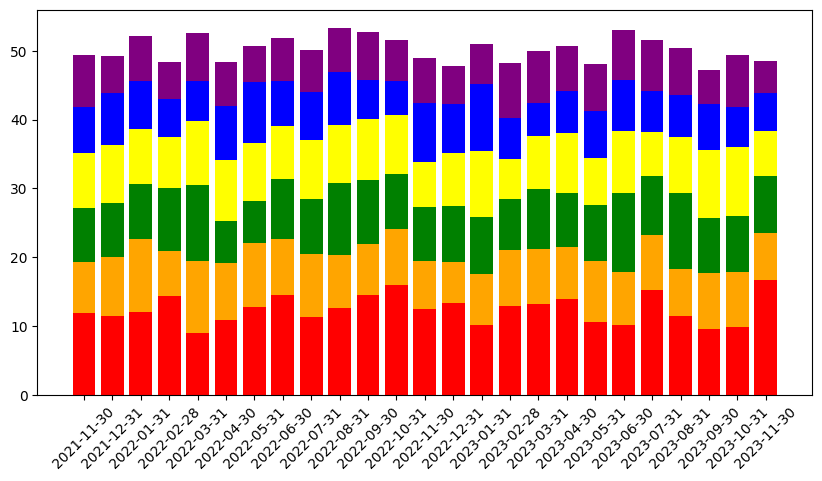

In [160]:
### Problem 2b: Reformat the data and generate the stacked bar plot above.


fig, ax = plt.subplots(figsize = (10, 5))

# ax.bar(topic_per_pivot['date'], topic_per_pivot[0], width = 0.5, color='blue', label = 'Party A')
ax.bar(tot_topa_answered_rate_pivot['sdate'], tot_topa_not_answered_rate_pivot[0], color='red', label = 'Party A')
ax.bar(tot_topa_answered_rate_pivot['sdate'], tot_topa_not_answered_rate_pivot[1], bottom = tot_topa_not_answered_rate_pivot[0], color = 'orange', label = 'Party B')
ax.bar(tot_topa_answered_rate_pivot['sdate'], tot_topa_not_answered_rate_pivot[2], bottom = tot_topa_not_answered_rate_pivot[1] + tot_topa_not_answered_rate_pivot[0], color = 'green', label = 'Party B')
ax.bar(tot_topa_answered_rate_pivot['sdate'], tot_topa_not_answered_rate_pivot[3], bottom = tot_topa_not_answered_rate_pivot[2] + tot_topa_not_answered_rate_pivot[1] + tot_topa_not_answered_rate_pivot[0], color = 'yellow', label = 'Party B')
ax.bar(tot_topa_answered_rate_pivot['sdate'], tot_topa_not_answered_rate_pivot[4], bottom = tot_topa_not_answered_rate_pivot[3] + tot_topa_not_answered_rate_pivot[2] + tot_topa_not_answered_rate_pivot[1] + tot_topa_not_answered_rate_pivot[0], color = 'blue', label = 'Party B')
ax.bar(tot_topa_answered_rate_pivot['sdate'], tot_topa_not_answered_rate_pivot[5], bottom = tot_topa_not_answered_rate_pivot[4] + tot_topa_not_answered_rate_pivot[3] + tot_topa_not_answered_rate_pivot[2] + tot_topa_not_answered_rate_pivot[1] + tot_topa_not_answered_rate_pivot[0], color = 'purple', label = 'Party B')


# ax.set_xlabel('Congress', fontsize = 5, labelpad = 20)
# ax.set_xlabel('Congress', fontsize = 5)
# ax.set_ylabel('Number of Seats', fontsize = 5, labelpad = 20)
# ax.set_title('Partisan Composition of Congress', fontsize = 17.5, pad = 20)

# ax.tick_params(axis = 'both', labelsize = 5)

# ax.legend(title = "Political Party",
#           title_fontsize = 15, fontsize = 5,
#           bbox_to_anchor = (1, 0.55))

plt.xticks(rotation = 45)
plt.show();

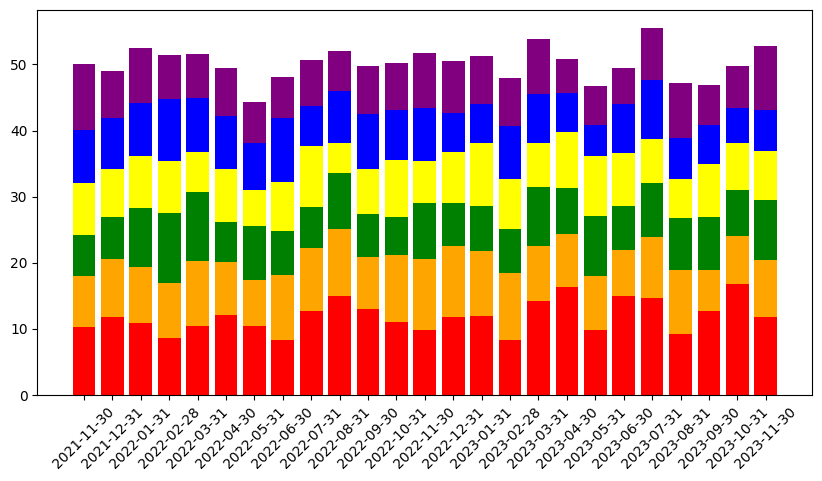

In [161]:
### Problem 2b: Reformat the data and generate the stacked bar plot above.


fig, ax = plt.subplots(figsize = (10, 5))

# ax.bar(topic_per_pivot['date'], topic_per_pivot[0], width = 0.5, color='blue', label = 'Party A')
ax.bar(tot_topa_answered_rate_pivot['sdate'], tot_topa_answered_rate_pivot[0], color='red', label = 'Party A')
ax.bar(tot_topa_answered_rate_pivot['sdate'], tot_topa_answered_rate_pivot[1], bottom = tot_topa_answered_rate_pivot[0], color = 'orange', label = 'Party B')
ax.bar(tot_topa_answered_rate_pivot['sdate'], tot_topa_answered_rate_pivot[2], bottom = tot_topa_answered_rate_pivot[1] + tot_topa_answered_rate_pivot[0], color = 'green', label = 'Party B')
ax.bar(tot_topa_answered_rate_pivot['sdate'], tot_topa_answered_rate_pivot[3], bottom = tot_topa_answered_rate_pivot[2] + tot_topa_answered_rate_pivot[1] + tot_topa_answered_rate_pivot[0], color = 'yellow', label = 'Party B')
ax.bar(tot_topa_answered_rate_pivot['sdate'], tot_topa_answered_rate_pivot[4], bottom = tot_topa_answered_rate_pivot[3] + tot_topa_answered_rate_pivot[2] + tot_topa_answered_rate_pivot[1] + tot_topa_answered_rate_pivot[0], color = 'blue', label = 'Party B')
ax.bar(tot_topa_answered_rate_pivot['sdate'], tot_topa_answered_rate_pivot[5], bottom = tot_topa_answered_rate_pivot[4] + tot_topa_answered_rate_pivot[3] + tot_topa_answered_rate_pivot[2] + tot_topa_answered_rate_pivot[1] + tot_topa_answered_rate_pivot[0], color = 'purple', label = 'Party B')


# ax.set_xlabel('Congress', fontsize = 5, labelpad = 20)
# ax.set_xlabel('Congress', fontsize = 5)
# ax.set_ylabel('Number of Seats', fontsize = 5, labelpad = 20)
# ax.set_title('Partisan Composition of Congress', fontsize = 17.5, pad = 20)

# ax.tick_params(axis = 'both', labelsize = 5)

# ax.legend(title = "Political Party",
#           title_fontsize = 15, fontsize = 5,
#           bbox_to_anchor = (1, 0.55))

plt.xticks(rotation = 45)
plt.show();

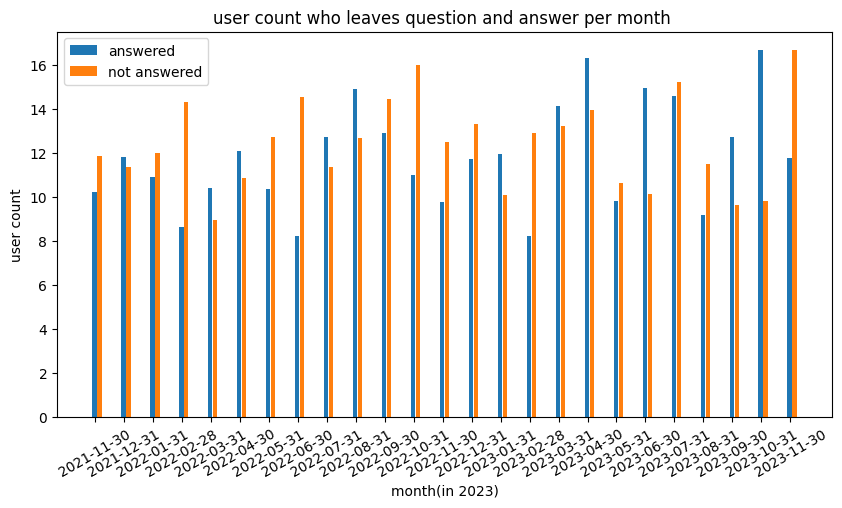

In [162]:
idx = np.arange(tot_topa_answered_rate_pivot.shape[0])
w = 0.15

plt.figure(figsize = (10, 5))
plt.title('user count who leaves question and answer per month ')
plt.xlabel('month(in 2023)')
plt.ylabel('user count')
plt.bar(idx - w * w, tot_topa_answered_rate_pivot[0], width = w, label = 'answered')
plt.bar(idx + w, tot_topa_not_answered_rate_pivot[0], width = w, label = 'not answered')
plt.xticks(idx, tot_topa_answered_rate_pivot['sdate'], rotation = 30)
plt.legend(ncol = 1)
plt.show()

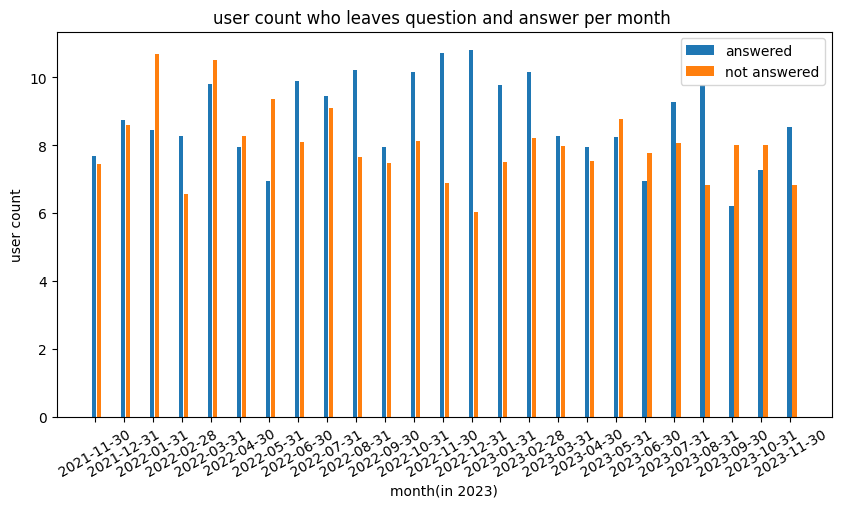

In [163]:
idx = np.arange(tot_topa_answered_rate_pivot.shape[0])
w = 0.15

plt.figure(figsize = (10, 5))
plt.title('user count who leaves question and answer per month ')
plt.xlabel('month(in 2023)')
plt.ylabel('user count')
plt.bar(idx - w * w, tot_topa_answered_rate_pivot[1], width = w, label = 'answered')
plt.bar(idx + w, tot_topa_not_answered_rate_pivot[1], width = w, label = 'not answered')
plt.xticks(idx, tot_topa_answered_rate_pivot['sdate'], rotation = 30)
plt.legend(ncol = 1)
plt.show()

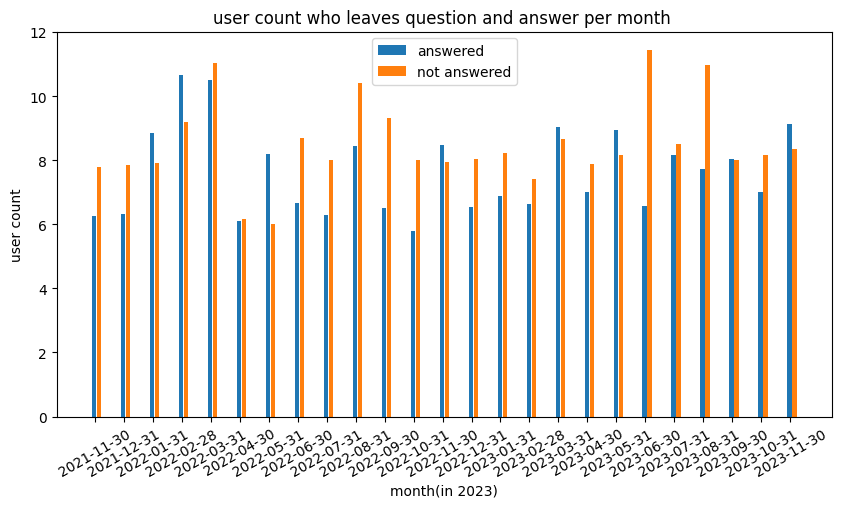

In [164]:
idx = np.arange(tot_topa_answered_rate_pivot.shape[0])
w = 0.15

plt.figure(figsize = (10, 5))
plt.title('user count who leaves question and answer per month ')
plt.xlabel('month(in 2023)')
plt.ylabel('user count')
plt.bar(idx - w * w, tot_topa_answered_rate_pivot[2], width = w, label = 'answered')
plt.bar(idx + w, tot_topa_not_answered_rate_pivot[2], width = w, label = 'not answered')
plt.xticks(idx, tot_topa_answered_rate_pivot['sdate'], rotation = 30)
plt.legend(ncol = 1)
plt.show()

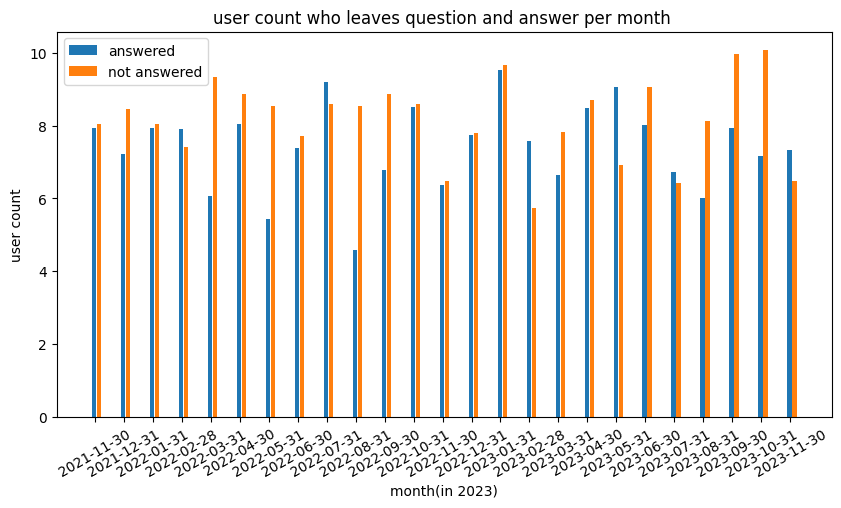

In [166]:
idx = np.arange(tot_topa_answered_rate_pivot.shape[0])
w = 0.15

plt.figure(figsize = (10, 5))
plt.title('user count who leaves question and answer per month ')
plt.xlabel('month(in 2023)')
plt.ylabel('user count')
plt.bar(idx - w * w, tot_topa_answered_rate_pivot[3], width = w, label = 'answered')
plt.bar(idx + w, tot_topa_not_answered_rate_pivot[3], width = w, label = 'not answered')
plt.xticks(idx, tot_topa_answered_rate_pivot['sdate'], rotation = 30)
plt.legend(ncol = 1)
plt.show()

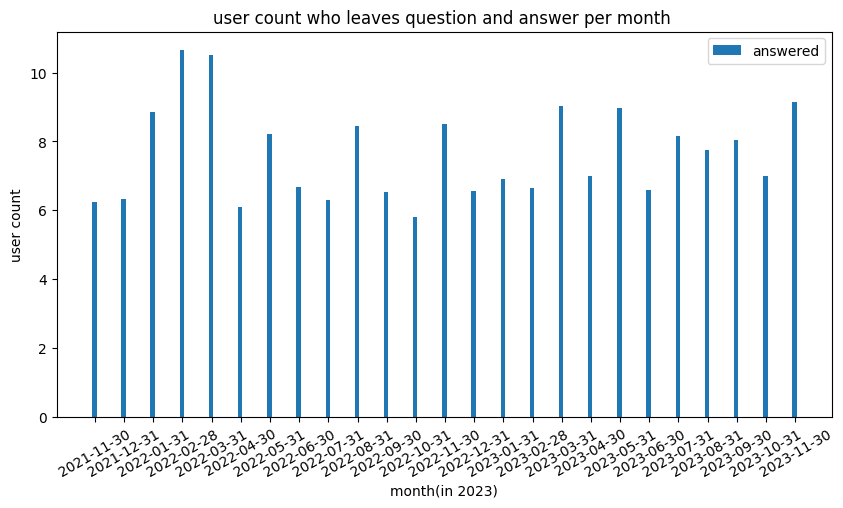

In [167]:
idx = np.arange(tot_topa_answered_rate_pivot.shape[0])
w = 0.15

plt.figure(figsize = (10, 5))
plt.title('user count who leaves question and answer per month ')
plt.xlabel('month(in 2023)')
plt.ylabel('user count')
plt.bar(idx - w * w, tot_topa_answered_rate_pivot[2], width = w, label = 'answered')
# plt.bar(idx + w, tot_topa_not_answered_rate_pivot[3], width = w, label = 'answer count')
plt.xticks(idx, tot_topa_answered_rate_pivot['sdate'], rotation = 30)
plt.legend(ncol = 1)
plt.show()